In [12]:
import pandas as pd
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, log_loss

In [13]:
# Load pre-split data
train = pd.read_csv("../data/processed_data/train.csv")
val   = pd.read_csv("../data/processed_data/val.csv")

In [14]:
# y_val er fasit, target_actual
y_val = val["target_actual"]

# Naiv prediksjon: bruk target_sched direkte
y_pred_baseline = val["target_sched"]

# For log loss og AUC trenger vi "sannsynligheter".
# Vi kan bruke target_sched som sannsynlighet (0 eller 1).
auc_baseline = roc_auc_score(y_val, y_pred_baseline)
eps = 1e-3  # lite justeringsledd
y_pred_proba = val["target_sched"].replace({0: eps, 1: 1-eps})

logloss_baseline = log_loss(y_val, y_pred_proba)

print("Baseline AUC:", auc_baseline)
print("Baseline Log Loss:", logloss_baseline)

Baseline AUC: 0.8048600199136711
Baseline Log Loss: 1.329250766610162


In [15]:
y_train = train["target_actual"]
p_majority = y_train.mean()  # andel positive i trening
y_pred_proba = [p_majority] * len(y_val)

logloss_baseline = log_loss(y_val, y_pred_proba)
auc_baseline = roc_auc_score(y_val, y_pred_proba)
print("Baseline AUC:", auc_baseline)
print("Baseline Log Loss:", logloss_baseline)

Baseline AUC: 0.5
Baseline Log Loss: 0.6482079951688112


In [16]:
train.head()

,airport_group,hour,target_actual,target_sched,flights_cnt,avg_duration,max_duration,avg_delay,max_delay,passenger_share,...,charter_share,dow,holiday,month,hournum,weekend,date,daily_flights_cnt,flights_cnt_prev,flights_cnt_next
0,C,2018-01-01 07:00:00,0,1,2,27.5,35.0,-7.000000,-2.0,1.0,...,0.0,0,True,1,7,0,2018-01-01,27,0,3
1,C,2018-01-01 08:00:00,1,1,3,40.0,80.0,-4.333333,-2.0,1.0,...,0.0,0,True,1,8,0,2018-01-01,27,2,2
2,G,2018-01-01 09:00:00,0,0,1,67.0,67.0,-9.000000,-9.0,1.0,...,0.0,0,True,1,9,0,2018-01-01,32,0,3
3,D,2018-01-01 09:00:00,0,0,2,42.5,50.0,-3.000000,-1.0,1.0,...,0.0,0,True,1,9,0,2018-01-01,31,0,3
4,C,2018-01-01 09:00:00,1,1,2,27.5,30.0,-8.500000,-6.0,1.0,...,0.0,0,True,1,9,0,2018-01-01,27,3,1


In [20]:
# Define features
cat_cols = ["airport_group"]  
num_cols = [
    "flights_cnt", "avg_duration", "max_duration",
    "passenger_share", "cargo_share", "charter_share",
    "dow", "month", "hournum", "weekend",
    "target_sched", "holiday", "daily_flights_cnt",
    "flights_cnt_prev",	"flights_cnt_next"
]
feature_cols = cat_cols + num_cols

# Separate X / y
X_train = train[feature_cols]
y_train = train["target_actual"]

X_val = val[feature_cols]
y_val = val["target_actual"]

# Preprocessing
preprocess = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ("num", "passthrough", num_cols)
])

# Model
rf_model = Pipeline([
    ("preprocess", preprocess),
    ("clf", RandomForestClassifier(
        n_estimators=200,
        max_depth=20,
        random_state=42,
        n_jobs=-1
    ))
])

# Train and evaluate
rf_model.fit(X_train, y_train)

print("Accuracy:", rf_model.score(X_val, y_val))
y_proba = rf_model.predict_proba(X_val)[:, 1]
print("AUC:", roc_auc_score(y_val, y_proba))
print("Log Loss:", log_loss(y_val, y_proba))


Accuracy: 0.9062214769374456
AUC: 0.9663558085115291
Log Loss: 0.20850752258545827


In [21]:
# Hent transformeren for kategoriske features
ohe = rf_model.named_steps["preprocess"].named_transformers_["cat"]

# Feature-navn for kategoriske
cat_feature_names = list(ohe.get_feature_names_out(["airport_group"]))

# Kombiner med numeriske
all_feature_names = cat_feature_names + num_cols
importances = rf_model.named_steps["clf"].feature_importances_

feat_importance = pd.DataFrame({
    "feature": all_feature_names,
    "importance": importances
}).sort_values("importance", ascending=False)

print(feat_importance.head(15))

              feature  importance
7         flights_cnt    0.550873
17       target_sched    0.160310
8        avg_duration    0.078706
9        max_duration    0.043964
15            hournum    0.034306
19  daily_flights_cnt    0.030868
14              month    0.020118
20   flights_cnt_prev    0.018366
21   flights_cnt_next    0.017428
13                dow    0.013377
1     airport_group_B    0.009271
0     airport_group_A    0.004304
6     airport_group_G    0.003159
3     airport_group_D    0.002936
16            weekend    0.002590


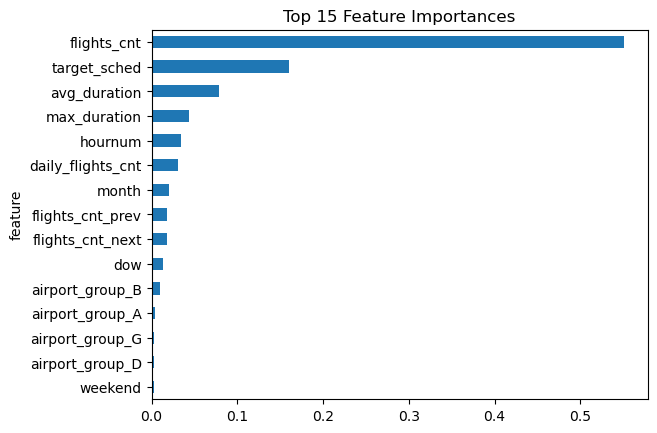

In [22]:
import matplotlib.pyplot as plt

feat_importance.head(15).plot(kind="barh", x="feature", y="importance", legend=False)
plt.title("Top 15 Feature Importances")
plt.gca().invert_yaxis()
plt.show()